In [1]:
%matplotlib notebook  
# instead of matplotlib inline. It turns the notebook interactive
import matplotlib.pyplot as plt
from matplotlib import animation          # 
from IPython.display import display, Image
from IPython.display import HTML
import numpy as np

# Function that fits a curve to data 
from scipy.optimize import curve_fit

import matplotlib.ticker as ticker

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
## Test histogram

_A histogram_ is an approximate representation of the distribution of numerical or categorical data. Read up on histograms here: [https://en.wikipedia.org/wiki/Histogram](https://en.wikipedia.org/wiki/Histogram) . 
In physics, the energy spectrum of a particle is the number of particles or intensity of a particle beam as a function of particle energy. 

<IPython.core.display.Javascript object>


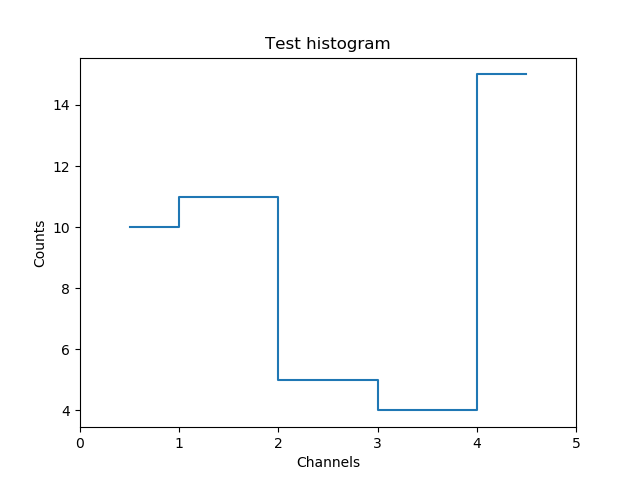

(0, 5)

In [4]:
bin_edges = np.array([0, 1, 2, 3, 4, 5])
bin_centers = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
y = [10, 11, 5, 4, 15]


plt.figure()
plt.step(bin_centers, y, where='mid')

plt.title("Test histogram")
plt.xlabel("Channels")
plt.ylabel("Counts")
plt.xlim([0, 5])


## Detector read out 

Generating data for detector read out chain:

In [5]:
N = 10

Preamplifier:

In [6]:
V_preamp = np.random.uniform(low=0.5, high=8, size=(N))

t_rising = 5
pream_t1 = np.linspace(0, t_rising, num=10)
pream_t2 = np.linspace(0, 100, num=100)

pream_t = np.concatenate([pream_t1, pream_t2+t_rising])
#print(pream_t.size)

def LinearFunc(x, k, m):
    return k*x + m

def ExpFunc(x, a, b):
    return a* np.exp(-x/30)


pream_y1 = np.zeros((N, pream_t1.size))
pream_y2 = np.zeros((N, pream_t2.size))

for i, V in enumerate(V_preamp):
    guess = [2, 1]
    xdata = np.array([0, t_rising])
    ydata = np.array([0, V])
    estimates, covarience = curve_fit(LinearFunc,
                                    xdata,
                                    ydata,
                                    p0 = guess)
    pream_y1[i] = LinearFunc(pream_t1, estimates[0], estimates[1])
    
for i, V in enumerate(V_preamp):
    pream_y2[i] = ExpFunc(pream_t2, V, 10)
    
# plt.figure(figsize=(12, 8))
# # with the data read in with the first routine
# plt.plot(np.concatenate([pream_t1, pream_t2+5]), np.concatenate([pream_y1[1], pream_y2[1]]))
#print(np.concatenate([pream_y1[1], pream_y2[1]]).size)

/usr/lib/python3.8/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Shaper/Amplifier + ADC

In [7]:
def GaussFunc(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

N_ref = 8
shaper_time = 5
shaper_x = np.linspace(0, shaper_time, num=50)
shaper_y = np.zeros((N, shaper_x.size))

A_arr = V_preamp
mu = 2.5
sigma = 0.5

#### Generate random Gaussians for 
for i in range(N):
    shaper_y[i] = GaussFunc(shaper_x, A_arr[i], mu, sigma)
    


 Histograming Gaussians :

In [8]:
# creating array of bin edges 
bin_edges = np.linspace(0, N_ref, num=N_ref+1)
# finding bin centers 
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# filling histogram
adc_y = np.zeros((N, N_ref+1))
for j, A in enumerate(A_arr): 
    i = 0
    while A > bin_edges[i]:
        i+=1
    adc_y[j, i-1] = 1

for i in range(N-1):
    adc_y[i+1] = adc_y[i+1] + adc_y[i]    


Visualizing data as animation:

<IPython.core.display.Javascript object>


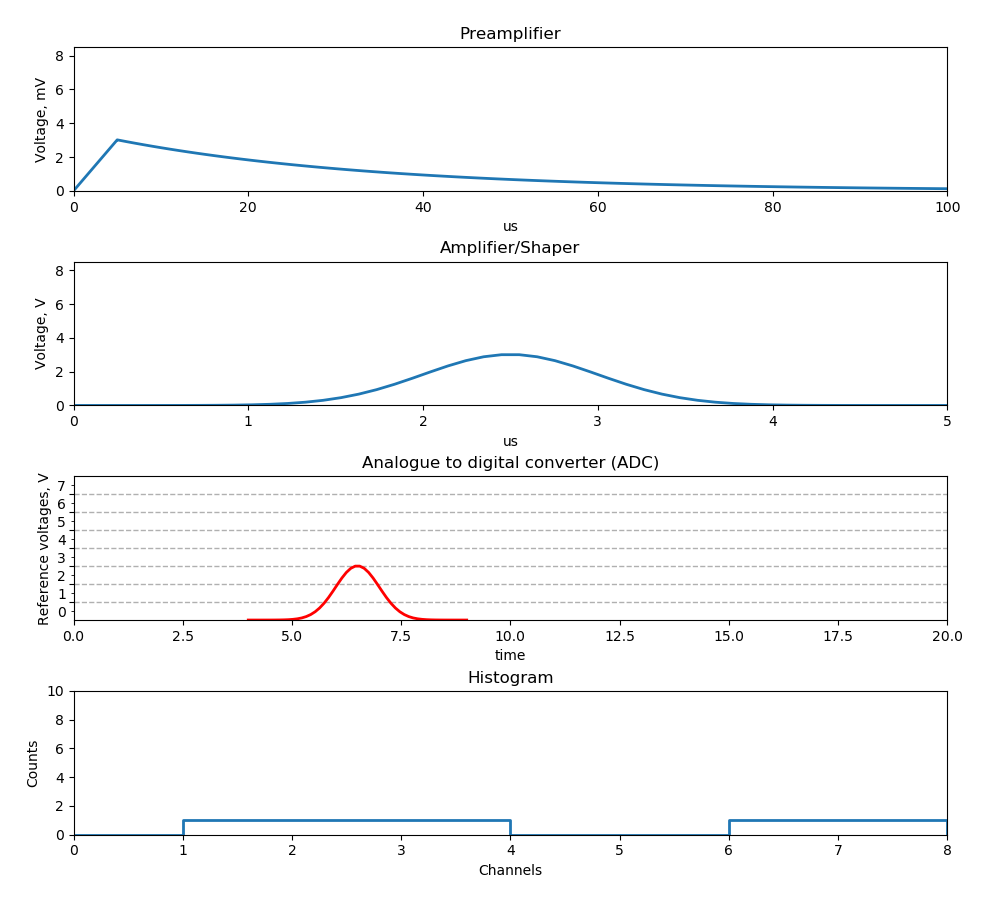

In [10]:
# First set up the figure, the axis, and the plot element we want to animate
# create a figure with two subplots
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1)
fig.set_size_inches(10, 9)
fig.tight_layout(pad=3.0)


### Preamp plot 
ax0.set(xlim=(0, 100), ylim=(0, N_ref+0.5), xlabel='us', ylabel='Voltage, mV') 

### Shaper plot 
ax1.set(xlim=(0, 5), ylim=(0, N_ref+0.5), xlabel='us', ylabel='Voltage, V') 

### ADC plot 
ax2.set(xlim=(0, 20), ylim=(0, N_ref), xlabel='time', ylabel='Reference voltages, V') 

# major ticks - to set grid on (labels off)
major_ticks = np.arange(1, N_ref, 1)
ax2.set_yticks(major_ticks)
ax2.set_yticklabels([], major=True)
ax2.grid(axis='y',  linestyle='--', linewidth=1, which='major')

# minor ticks - to set labels 
minor_ticks = np.arange(0.5, N_ref+0.5, 1)
ax2.set_yticks(minor_ticks, minor=True)
ax2.set_yticklabels(np.arange(0, N_ref, 1), minor=True)

### Histogram plot
ax3.set(xlim=(0, N_ref), ylim=(0, 10), xlabel='Channels', ylabel='Counts') 

#xlabel='$\micro$s', ylabel='$V$'
#xlabel='$\micro$s', ylabel='Reference voltages'

ax0.title.set_text('Preamplifier')
ax1.title.set_text('Amplifier/Shaper')
ax2.title.set_text('Analogue to digital converter (ADC)')
ax3.title.set_text('Histogram')

line0, = ax0.plot([], [], lw=2)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
#line3, = ax3.step([], [], lw=2, where='post')
line3, = ax3.step([], [], lw=2, where='post')
line = [line0, line1, line2, line3]

# # Initialization function: draws first frame on video. (empty box in this case)
# def init():
#     line.set_data([], [])                     # the line has no data
#     return line,
#


# Animation function which updates figure data.  This is called sequentially
def animate(i):
    line[0].set_data(pream_t, np.concatenate([pream_y1[i], pream_y2[i]]))            # line graph of x and y coordinates
    #line[0].set_data(shaper_x, shaper_y[i])            # line graph of x and y coordinates
    line[1].set_data(shaper_x, shaper_y[i])            # line graph of x and y coordinates
    line[2].set_data(shaper_x + i, shaper_y[i])            # line graph of x and y coordinates
    line[3].set_data(bin_edges, adc_y[i]) 
    #line[2].set_data(bin_centers, adc_y[i])
    return line,

# Call the animator.  
# Draws in Fig
# calls animate(i) for every i in frames
# delay between frames in miliseconds
# blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, 
                               frames=range(N), interval=1000, blit=True)
